### **CSE 5095: Social Media Mining and Analysis: Fall 2024, Assignment #3, 200 points**

In this assignment, we will explore neural word embedding methods to build a classification framework to separate the observations according to the two subreddits.


**__Task 1: Word2Vec -- Feature Word Vectors (20 points)__**

Your starting point to build feature word vectors will be the pruned vocabulary that you have determined in Task 4 of Assignment #2. Pre-load Word2Vec embeddings and generate feature word vectors for this pruned or shortened vocabulary. Choose two most prominent words from each subreddit, by considering the word clouds from Assignment #1. Compute pairwise cosine similarity between the word embedding vectors of these four words. 

Loading pre-trained Word2Vec model...
Calculating pairwise cosine similarities...

Pairwise Cosine Similarities:
word2      action    change   climate    fossil    people      post
word1                                                              
action        NaN  0.192842  0.108644       NaN       NaN  0.084183
change   0.192842       NaN  0.175553  0.065364  0.160744  0.040262
climate  0.108644  0.175553       NaN  0.239409  0.093152  0.034188
fossil        NaN  0.065364  0.239409       NaN  0.036323       NaN
people        NaN  0.160744  0.093152  0.036323       NaN       NaN
post     0.084183  0.040262  0.034188       NaN       NaN       NaN


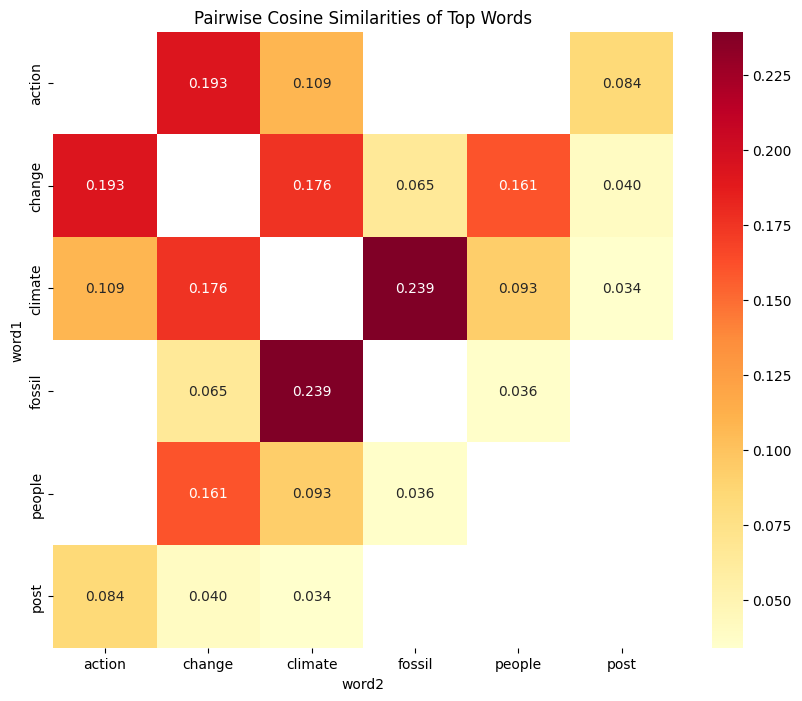

In [6]:
import gensim.downloader as api
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
# Visualize the similarities
import matplotlib.pyplot as plt
import seaborn as sns

# Load pre-trained Word2Vec model
print("Loading pre-trained Word2Vec model...")
w2v_model = api.load("word2vec-google-news-300")

# Get the most prominent words from each subreddit
subreddit_top_words = {
    'science': ['climate', 'change', 'fossil', 'people'],
    'action': ['climate', 'change', 'action', 'post']
}

# Compute pairwise cosine similarities
print("Calculating pairwise cosine similarities...")
similarities = []
for subreddit, words in subreddit_top_words.items():
    for word1 in words:
        for word2 in words:
            if word1 != word2:
                sim = cosine_similarity([w2v_model[word1]], [w2v_model[word2]])[0][0]
                similarities.append({
                    'word1': word1,
                    'word2': word2,
                    'subreddit': subreddit,
                    'similarity': sim
                })

similarity_df = pd.DataFrame(similarities)

# Pivot the DataFrame to create a matrix
print("\nPairwise Cosine Similarities:")
similarity_matrix = similarity_df.pivot_table(index='word1', columns='word2', values='similarity', aggfunc='mean')
print(similarity_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Pairwise Cosine Similarities of Top Words')
plt.show()

**Task 2: Sentence Word Vectors & ML Models (80 points – 10 points, 15 for each aggregation strategy, and 40 points for four ML models)**

Build sentence vectors based on the feature word vectors. Feed the sentence vectors into the four ML models used in Assignment #1. Try at least two approaches for aggregating the word feature vectors into sentence vectors. Candidates include simple averaging, or weighted averaging with weights determined by TF-IDF scores, or any other ways of combining the feature vectors of words into sentence vectors and compare the performance metrics for these two approaches. Identify the aggregating approach that offers the best performance. ML modeling should implement the train/test split and all other details that are outlined in Assignment #2.

In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the data
df = pd.read_csv('project10.csv')

def preprocess_text(text):
    if pd.isna(text) or text is None:
        return ''
    
    text = str(text).lower()
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    text = ' '.join(text.split())
    
    return text

def combine_text_fields(row):
    fields = [
        str(row['post_title']) if not pd.isna(row['post_title']) else '',
        str(row['post_self_text']) if not pd.isna(row['post_self_text']) else '',
        str(row['self_text']) if not pd.isna(row['self_text']) else ''
    ]
    return ' '.join(field for field in fields if field)

def get_top_words_per_subreddit(df, n_words=50, min_df=5):

    df['combined_text'] = df.apply(combine_text_fields, axis=1)
    df['combined_text'] = df['combined_text'].apply(preprocess_text)

    df = df[df['combined_text'].str.len() > 0].copy()
    
    tfidf = TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        min_df=min_df,
        token_pattern=r'\b[a-zA-Z]{3,}\b'
    )
    
    subreddit_top_words = {}
    
    for subreddit in df['subreddit'].unique():
        subreddit_texts = df[df['subreddit'] == subreddit]['combined_text']
        
        if len(subreddit_texts) == 0:
            continue
            
        try:
            tfidf_matrix = tfidf.fit_transform(subreddit_texts)
            feature_names = np.array(tfidf.get_feature_names_out())
            
            mean_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
            
            top_indices = mean_tfidf.argsort()[-n_words:][::-1]
            
            subreddit_top_words[subreddit] = {
                'words': feature_names[top_indices],
                'scores': mean_tfidf[top_indices]
            }
        except ValueError as e:
            print(f"Error processing subreddit {subreddit}: {str(e)}")
            continue
    
    return subreddit_top_words

# Preprocess the text
df['combined_text'] = df.apply(combine_text_fields, axis=1)
df['combined_text'] = df['combined_text'].apply(preprocess_text)
df = df[df['combined_text'].str.len() > 0].copy()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['combined_text'], df['subreddit'], test_size=0.2, random_state=42, stratify=df['subreddit'])

# Build TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, min_df=5, stop_words='english', token_pattern=r'\b[a-zA-Z]{3,}\b')

# Simple average of word vectors
print("Building sentence vectors using simple averaging...")
X_train_avg = np.array([np.mean([w2v_model[w] for w in text.split() if w in w2v_model], axis=0) for text in X_train])
X_test_avg = np.array([np.mean([w2v_model[w] for w in text.split() if w in w2v_model], axis=0) for text in X_test])

# TF-IDF weighted average of word vectors
print("Building sentence vectors using TF-IDF weighted averaging...")
tfidf.fit(X_train)
X_train_tfidf = np.array([np.average([w2v_model[w] for w in text.split() if w in w2v_model], axis=0, weights=[tfidf.idf_[tfidf.vocabulary_.get(w, 0)] for w in text.split() if w in w2v_model]) for text in X_train])
X_test_tfidf = np.array([np.average([w2v_model[w] for w in text.split() if w in w2v_model], axis=0, weights=[tfidf.idf_[tfidf.vocabulary_.get(w, 0)] for w in text.split() if w in w2v_model]) for text in X_test])

# Train and evaluate models
print("Training and evaluating models...")
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': LinearSVC(max_iter=1000)
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Simple average
    model.fit(X_train_avg, y_train)
    y_pred_avg = model.predict(X_test_avg)
    print(f"{name} (Simple Average):")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_avg):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_avg, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_avg, average='weighted'):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred_avg, average='weighted'):.4f}")
    
    # TF-IDF weighted average
    model.fit(X_train_tfidf, y_train)
    y_pred_tfidf = model.predict(X_test_tfidf)
    print(f"{name} (TF-IDF Weighted Average):")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_tfidf):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_tfidf, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_tfidf, average='weighted'):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred_tfidf, average='weighted'):.4f}")

Building sentence vectors using simple averaging...
Building sentence vectors using TF-IDF weighted averaging...
Training and evaluating models...

Training Logistic Regression...
Logistic Regression (Simple Average):
Accuracy: 0.7924
Precision: 0.7901
Recall: 0.7924
F1-score: 0.7767
Logistic Regression (TF-IDF Weighted Average):
Accuracy: 0.7863
Precision: 0.7826
Recall: 0.7863
F1-score: 0.7702

Training Random Forest...
Random Forest (Simple Average):
Accuracy: 0.8092
Precision: 0.8169
Recall: 0.8092
F1-score: 0.7913
Random Forest (TF-IDF Weighted Average):
Accuracy: 0.8000
Precision: 0.8125
Recall: 0.8000
F1-score: 0.7774

Training SVM...
SVM (Simple Average):
Accuracy: 0.7985
Precision: 0.7925
Recall: 0.7985
F1-score: 0.7921
SVM (TF-IDF Weighted Average):
Accuracy: 0.7878
Precision: 0.7810
Recall: 0.7878
F1-score: 0.7808


**Task 3: Augmenting with Metadata Features (20 points)**

For the aggregating approach that you identify in Task 2 as providing the best performance, augment the sentence vectors with the quantitative metadata features. Re-run the ML models and compare their performance.

In [10]:
X_train_aug = np.concatenate((X_train_tfidf, df.loc[X_train.index, ['post_score', 'post_upvote_ratio', 'post_thumbs_ups']].values), axis=1)
X_test_aug = np.concatenate((X_test_tfidf, df.loc[X_test.index, ['post_score', 'post_upvote_ratio', 'post_thumbs_ups']].values), axis=1)

# Train and evaluate models
print("Training and evaluating models...")
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': LinearSVC(max_iter=1000)
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # TF-IDF weighted average with metadata
    model.fit(X_train_aug, y_train)
    y_pred_aug = model.predict(X_test_aug)
    print(f"{name} (TF-IDF Weighted Average + Metadata):")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_aug):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_aug, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_aug, average='weighted'):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred_aug, average='weighted'):.4f}")

Training and evaluating models...

Training Logistic Regression...
Logistic Regression (TF-IDF Weighted Average + Metadata):
Accuracy: 0.7969
Precision: 0.7967
Recall: 0.7969
F1-score: 0.7808

Training Random Forest...
Random Forest (TF-IDF Weighted Average + Metadata):
Accuracy: 0.8092
Precision: 0.8253
Recall: 0.8092
F1-score: 0.7876

Training SVM...
SVM (TF-IDF Weighted Average + Metadata):
Accuracy: 0.7817
Precision: 0.7744
Recall: 0.7817
F1-score: 0.7745


**Task 4: Deep Learning Models (80 points – 20 points each for each DL model)**

Build a deep learning pipeline by passing an embedding matrix to the initial embedding layer using Keras. You can choose four DL models, candidates include: LSTM, Bi-LSTM, CNN, RNN, etc. Compare the performance of these models with the performance of the ML models.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import gensim.downloader as api

def combine_text_fields(row):
    fields = [
        str(row['post_title']) if not pd.isna(row['post_title']) else '',
        str(row['post_self_text']) if not pd.isna(row['post_self_text']) else '',
        str(row['self_text']) if not pd.isna(row['self_text']) else ''
    ]
    return ' '.join(field for field in fields if field)

df['combined_text'] = df.apply(combine_text_fields, axis=1)

# Basic text preprocessing
df['combined_text'] = df['combined_text'].apply(lambda x: ' '.join(word.lower() for word in str(x).split()))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['combined_text'], 
    df['subreddit'], 
    test_size=0.2, 
    random_state=42,
    stratify=df['subreddit']
)

# Tokenization parameters
max_features = 20000  # Maximum number of words to keep
maxlen = 200         # Maximum length of each sequence

# Tokenize the text
print("Tokenizing text...")
tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad them
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

# Load pre-trained word embeddings
print("Loading pre-trained Word2Vec model...")
w2v_model = api.load("word2vec-google-news-300")

# Create embedding matrix with error handling
print("Creating embedding matrix...")
embedding_dim = 300
embedding_matrix = np.zeros((max_features, embedding_dim))
words_found = 0

for word, i in tokenizer.word_index.items():
    if i >= max_features:
        continue
    try:
        embedding_matrix[i] = w2v_model[word]
        words_found += 1
    except KeyError:
        # If word not in W2V vocabulary, initialize randomly
        embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)

print(f"Found {words_found} words in W2V vocabulary out of {min(len(tokenizer.word_index), max_features)} words")

# Define model architectures
def build_lstm_model(vocab_size, embedding_dim, embedding_matrix, maxlen):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(df['subreddit'].unique()), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

def build_bilstm_model(vocab_size, embedding_dim, embedding_matrix, maxlen):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(df['subreddit'].unique()), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

def build_cnn_model(vocab_size, embedding_dim, embedding_matrix, maxlen):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
        Conv1D(128, 5, activation='relu'),
        Conv1D(64, 3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(len(df['subreddit'].unique()), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

def build_rnn_model(vocab_size, embedding_dim, embedding_matrix, maxlen):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
        SimpleRNN(128, return_sequences=True),
        SimpleRNN(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(df['subreddit'].unique()), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Initialize models
models = {
    'LSTM': build_lstm_model(max_features, embedding_dim, embedding_matrix, maxlen),
    'Bi-LSTM': build_bilstm_model(max_features, embedding_dim, embedding_matrix, maxlen),
    'CNN': build_cnn_model(max_features, embedding_dim, embedding_matrix, maxlen),
    'RNN': build_rnn_model(max_features, embedding_dim, embedding_matrix, maxlen)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name} model...")
    history = model.fit(
        X_train_pad, 
        pd.get_dummies(y_train),
        epochs=5,  # Reduced epochs for demonstration
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    
    # Make predictions
    y_pred = model.predict(X_test_pad)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_numeric = pd.factorize(y_test)[0]
    
    # Calculate metrics
    results[name] = {
        'accuracy': accuracy_score(y_test_numeric, y_pred_classes),
        'precision': precision_score(y_test_numeric, y_pred_classes, average='weighted'),
        'recall': recall_score(y_test_numeric, y_pred_classes, average='weighted'),
        'f1': f1_score(y_test_numeric, y_pred_classes, average='weighted')
    }
    
    print(f"\n{name} Results:")
    for metric, value in results[name].items():
        print(f"{metric.capitalize()}: {value:.4f}")

# Print comparative results
print("\nComparative Results:")
metrics_df = pd.DataFrame(results).round(4)
print(metrics_df)

Tokenizing text...
Loading pre-trained Word2Vec model...
Creating embedding matrix...
Found 14270 words in W2V vocabulary out of 18940 words


c:\Users\mso21001\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training LSTM model...
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.6815 - loss: 0.6377 - val_accuracy: 0.7366 - val_loss: 0.5599
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7362 - loss: 0.5845 - val_accuracy: 0.7481 - val_loss: 0.5636
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7218 - loss: 0.5824 - val_accuracy: 0.7519 - val_loss: 0.5523
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7520 - loss: 0.5540 - val_accuracy: 0.7347 - val_loss: 0.5685
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7327 - loss: 0.5753 - val_accuracy: 0.7328 - val_loss: 0.5751
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

LSTM Results:
Accuracy: 0.2656
Precision: 0.2686
Recall: 0.2656
F1: 0.1764

Training Bi-LSTM model...
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.7077 - loss: 0.5736 - val_accuracy: 0.8378 - val_loss: 0.4004
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.8292 - los